In [1]:
library(kernlab)
library(dplyr)
library(data.table)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last


Attaching package: ‘ggplot2’

The following object is masked from ‘package:kernlab’:

    alpha



In [2]:
options(repr.plot.width=3, repr.plot.height=3,repr.plot.family='Hirakaku-Pro-W3')
set.seed(1)

In [3]:
rkimu <- function(lambda,size,gamma){
    kekka <- rep(0,size)
    for(i in 1:size){
        z <- rnorm(length(lambda),mean=0,sd=sqrt(1/(gamma*(1-gamma))))
        kekka[i] <- sum(lambda*(z^2-1/(gamma*(1-gamma))))
    }
    return(kekka)
}
kernelTST <- function(X,Y){
    X <- as.matrix(X)
    Y <- as.matrix(Y)
    s <- sigest(rbind(X,Y),scaled=FALSE)[2]
    rbf <- rbfdot(sigma = s)
    nX <- dim(X)[1]
    nY <- dim(Y)[1]
    N <- nX+nY
    Kx <- kernelMatrix(x = X,kernel = rbf)
    Ky <- kernelMatrix(x = Y,kernel = rbf)
    
    #get U statistic
    diag(Kx)<-0;diag(Ky)<-0
    term1 <- sum(Kx)/(nX*(nX-1))
    term2 <- sum(Ky)/(nY*(nY-1))
    term3 <- 2*sum(kernelMatrix(x=X,y=Y,kernel=rbf))/(nX*nY)
    Ustatistic <- term1+term2-term3
    Nstatistic <- N*Ustatistic

    
    #get critical values
    one <- matrix(1,nX,1)
    H <- diag(nX) - 1/nX*(one%*%t(one))
    K <- kernelMatrix(x = X,kernel = rbf)
    centerd_K <- H%*%K%*%H
    lambda <- 1/nX*eigen(centerd_K)$values
    lambda_pos <- lambda[lambda>0.001]
    kimusample <- rkimu(lambda=lambda_pos,size=1000,gamma=1/2)
    criticalvalue <- sort(kimusample)[0.95*length(kimusample)]
    
   
    kimu.plot <- ggplot(data.frame(kimubunpu = kimusample),aes(kimubunpu))+geom_histogram(bins=30)+
        geom_vline(xintercept=criticalvalue,col='red',show.legend=TRUE)+
        geom_vline(xintercept=Nstatistic,linetype='dashed',show.legend=TRUE)
        
    
    kekka <- list(CV=criticalvalue,NU=Nstatistic,kimu='Rejected',kimu.plot)
    if (criticalvalue>Nstatistic){
        kekka$kimu = 'Accepted'
    }
    else{
        kekka$kimu = 'Rejected'
    }
    return(kekka)
}

$CV
[1] 3.26102

$NU
[1] 448.9454

$kimu
[1] "Rejected"

[[4]]


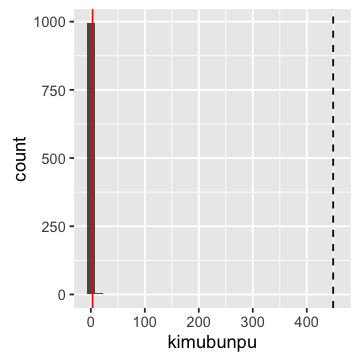

In [4]:
x <- rnorm(500,1,sd=sqrt(1/3))
y <- runif(500,-1,1)
kernelTST(x,y)

$CV
[1] 3.464451

$NU
[1] 18.91575

$kimu
[1] "Rejected"

[[4]]


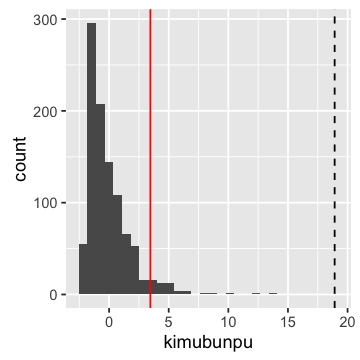

In [5]:
x <- runif(500,-1,1)
y <- runif(500,-1.2,1.2)
kernelTST(x,y)

## How many times rejected (100 trials)
### vs kolmogorov smirnov test.

In [6]:
kekka_ktst <- 0
for (i in 1:100){
    x <- rnorm(100,0,sd=1/3)
    y <- runif(100,-1,1)
    kekka_ktst <- kekka_ktst+(kernelTST(X=x,Y=y)$kimu=='Rejected')
}
kekka_ks <- 0
for (i in 1:100){
    x <- rnorm(100,0,sd=1/3)
    y <- runif(100,-1,1)
    kekka_ks <- kekka_ks+(ks.test(x,y)$p.value<0.05)
}
kekka_ktst
kekka_ks

[1] 100

[1] 92

In [7]:
kekka_ktst <- 0
for (i in 1:100){
    x <- rnorm(500,0,sd=1/3)
    y <- runif(500,-1,1)
    kekka_ktst <- kekka_ktst+(kernelTST(X=x,Y=y)$kimu=='Rejected')
}
kekka_ks <- 0
for (i in 1:100){
    x <- rnorm(500,0,sd=1/3)
    y <- runif(500,-1,1)
    kekka_ks <- kekka_ks+(ks.test(x,y)$p.value<0.05)
}
kekka_ktst
kekka_ks

[1] 100

[1] 100

In [8]:
kekka_ktst <- 0
for (i in 1:100){
    x <- runif(500,-1,1)
    y <- runif(500,-1.15,1.15)
    kekka_ktst <- kekka_ktst+(kernelTST(X=x,Y=y)$kimu=='Rejected')
}
kekka_ks <- 0
for (i in 1:100){
    x <- runif(500,-1,1)
    y <- runif(500,-1.15,1.15)
    kekka_ks <- kekka_ks+(ks.test(x,y)$p.value<0.05)
}
kekka_ktst
kekka_ks

[1] 79

[1] 45

All cases, kernel two sample test superior to kolmogorov smirnov test.

## Analysis of Iris data

In [9]:
data(iris)
setosa <- as.matrix(filter(iris,Species=='setosa')[,-5])
virginica <- as.matrix(filter(iris,Species=='virginica')[,-5])

### setosa vs virginica

$CV
[1] 0.2984661

$NU
[1] 130.29

$kimu
[1] "Rejected"

[[4]]


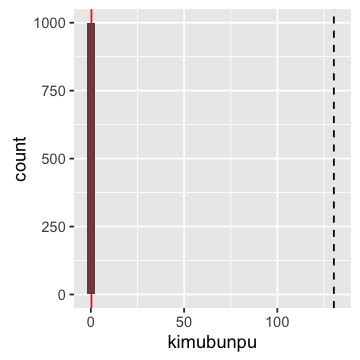

In [10]:
kernelTST(X=setosa,Y=virginica)

### setosa vs setosa (this should not be rejected)

$CV
[1] 2.706584

$NU
[1] -1.439217

$kimu
[1] "Accepted"

[[4]]


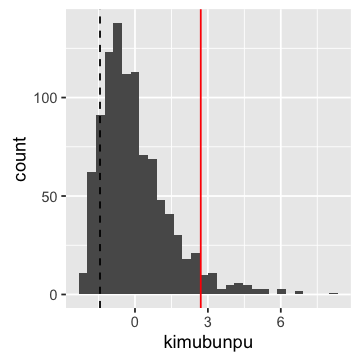

In [11]:
kernelTST(X=setosa[1:25,],Y=setosa[25:50,])